<a href="https://colab.research.google.com/github/maryisangediok/Computer-Vision/blob/main/skinCaner_vgg32_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.applications import VGG16, VGG19, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/')  # Add the path to 'ham.py' in your Drive
from ham import get_default_dataset, create_dataset, classes


In [ ]:
# Input features for your images
height = width = 32 # Only change this line if using a different image size
channel = 3
input_shape = (height, width, channel)
reshape = (-1,height,width,channel)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


RandomOversampler

In [ ]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

def collect_data(input_shape, resize=None):
    if resize is not None:
        height, width, channel = resize
    else:
        height, width, channel = input_shape

    # Use default dataset or generate the dataset (if using a different shape)
    if height == width == 28:
        data, testset, data_meta, testset_meta = get_default_dataset()
    else:
        data, testset, data_meta, testset_meta = create_dataset(resize=(height, width))

    y = data['label']
    x = data.drop(columns=['label'])

    # This process ensures that all the input features have the same scale,
    # which can help the model learn more effectively and prevent some features from dominating others.
    x = x.astype("float32") / 255.0
    x = np.array(x).reshape((-1, height, width, channel))

    return x, y, testset
#collect data
x, y, testset = collect_data(input_shape)

Downloading...
From: https://drive.google.com/uc?id=1vNLwZ4ao7eZTAeH0JRIhaZ1QbiP3LsDG
To: /content/file.zip
100%|██████████| 1.37G/1.37G [00:16<00:00, 84.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1w6eRHc4sKJ1jzh5gU112HK8mfgraqcIj
To: /content/file.zip
100%|██████████| 1.40G/1.40G [00:14<00:00, 96.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n71CVP_3-OpcwSaC6z1Y1JCyCznzVP9t
To: /content/file.zip
100%|██████████| 420M/420M [00:07<00:00, 57.5MB/s]


In [ ]:
def preprocess_data(x,y):
    # Split the data into training and validation sets
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=1)

    oversample = RandomOverSampler()
    # Reshape X_train to 2 dimensions
    X_train_flat = X_train.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])

    # Apply oversampling to the flattened X_train
    X_train_resampled, Y_train_resampled = oversample.fit_resample(X_train_flat, Y_train)
    # Reshape the flattened X_train_resampled back to its original shape
    X_train_resampled_reshaped = X_train_resampled.reshape(-1, x.shape[1], x.shape[2], x.shape[3])

    return X_train_resampled_reshaped, X_test, Y_train_resampled, Y_test

#preprocess data
X_train, X_test, Y_train, Y_test = preprocess_data(x,y)


In [ ]:
def train_model(model, X_train, Y_train):
    callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_accuracy', mode='max',
                                                  verbose=1)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size=128,
                        epochs=25,
                        callbacks=[callback])

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('model_accuracy.png')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('model_loss.png')
    plt.show()

    model.save('best_model.h5')
    model.save_weights('best_model_weights.h5')

    model = tf.keras.models.load_model('best_model.h5')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open("best_model.tflite", "wb").write(tflite_model)


In [ ]:
def evaluate_model(model, X_test, Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    confusion_mtx = confusion_matrix(Y_test, Y_pred_classes)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes.values())

    print('Validation Set Evaluation:')
    print(classification_report(np.float32(Y_test), Y_pred_classes.round()))


In [ ]:
def save_model(model, model_name):
    # Save model architecture
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    # Save model weights
    model.save_weights(f"{model_name}_weights.h5")
    print(f"Model saved as {model_name}.json and {model_name}_weights.h5")


def load_model(model_name):
    # Load model architecture
    json_file = open(f"{model_name}.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)

    # Load model weights
    loaded_model.load_weights(f"{model_name}_weights.h5")
    print(f"Model loaded from {model_name}.json and {model_name}_weights.h5")
    return loaded_model


def convert_to_tflite(model, model_name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(f"{model_name}.tflite", "wb") as tflite_file:
        tflite_file.write(tflite_model)
    print(f"Model converted to TensorFlow Lite format and saved as {model_name}.tflite")


In [ ]:
def test_model(model, testset):
    Y_testset = testset['label']
    X_testset = testset.drop(columns=['label'])

    X_testset = np.array(X_testset).reshape(reshape)
    X_testset = X_testset.astype("float32") / 255.0

    loss, accuracy = model.evaluate(X_testset, Y_testset, verbose=2)

    # Make predictions using the model
    Y_testset_pred = model.predict(X_testset)
    Y_testset_pred_classes = np.argmax(Y_testset_pred, axis=1)

    # Plot the confusion matrix
    confusion_mtx = confusion_matrix(Y_testset, Y_testset_pred_classes)
    plot_confusion_matrix(confusion_mtx, classes.values())

    print('Test Set Evaluation:')
    print(classification_report(Y_testset, Y_testset_pred_classes))


# VGG16

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/25
235/235 [==============================] - ETA: 0s - loss: 1.4158 - accuracy: 0.4674
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 15s 22ms/step - loss: 1.4158 - accuracy: 0.4674 - val_loss: 1.9858 - val_accuracy: 0.2704
Epoch 2/25
233/235 [============================>.] - ETA: 0s - loss: 1.0882 - accuracy: 0.5996
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 4s 18ms/step - loss: 1.0870 - accuracy: 0.6001 - val_loss: 2.0766 - val_accuracy: 0.3005
Epoch 3/25
233/235 [============================>.] - ETA: 0s - loss: 0.9435 - accuracy: 0.6554
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 4s 18ms/step - loss: 0.9437 - accuracy: 0.6552 - val_loss: 1.5804 - val_accuracy: 0.3913
Epoch 4/25
233/235 [============================>.] - ETA: 0s - loss: 0.8487 - accuracy: 0.6871
Epoch 4: saving model to best_model.h

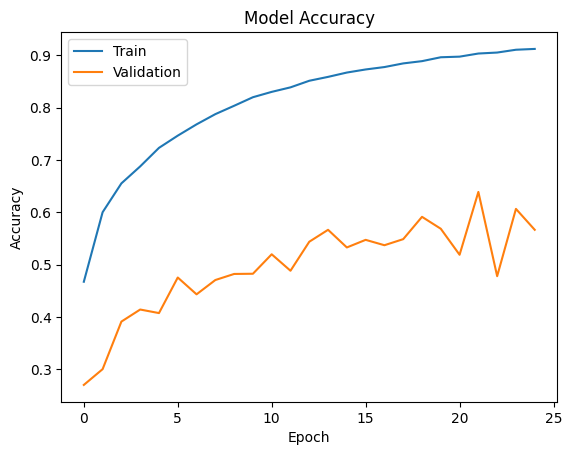

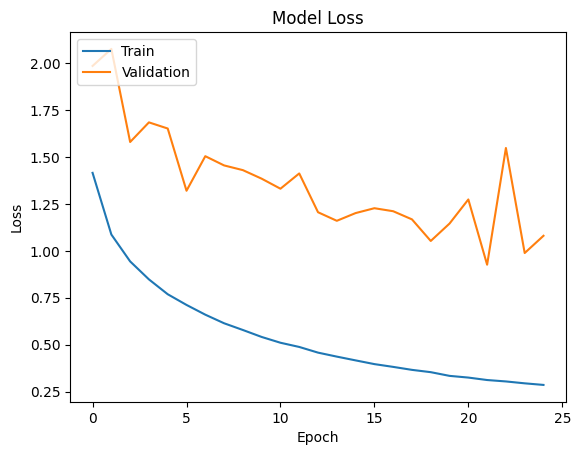

63/63 - 1s - loss: 1.1875 - accuracy: 0.6835 - 1s/epoch - 18ms/step
63/63 [==============================] - 1s 6ms/step
Validation Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.30      0.40      0.34        65
         1.0       0.34      0.42      0.38       103
         2.0       0.33      0.55      0.41       220
         3.0       0.16      0.26      0.20        23
         4.0       0.87      0.83      0.85      1341
         5.0       0.60      0.64      0.62        28
         6.0       0.51      0.19      0.28       223

    accuracy                           0.68      2003
   macro avg       0.45      0.47      0.44      2003
weighted avg       0.71      0.68      0.69      2003

48/48 - 1s - loss: 1.9219 - accuracy: 0.6003 - 616ms/epoch - 13ms/step
48/48 [==============================] - 0s 6ms/step
Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.16      0.26      0.19        43
 

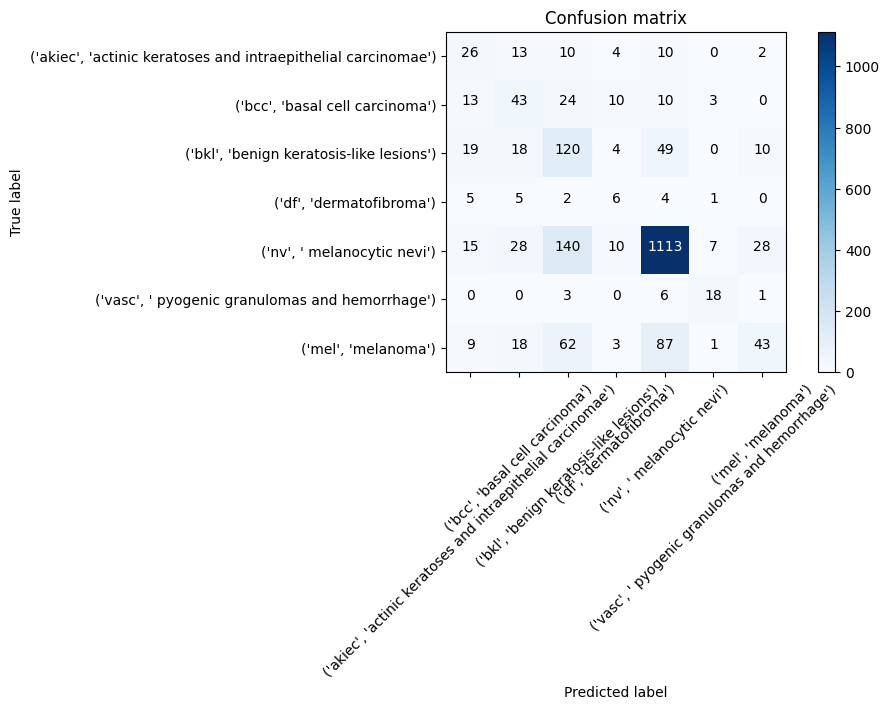

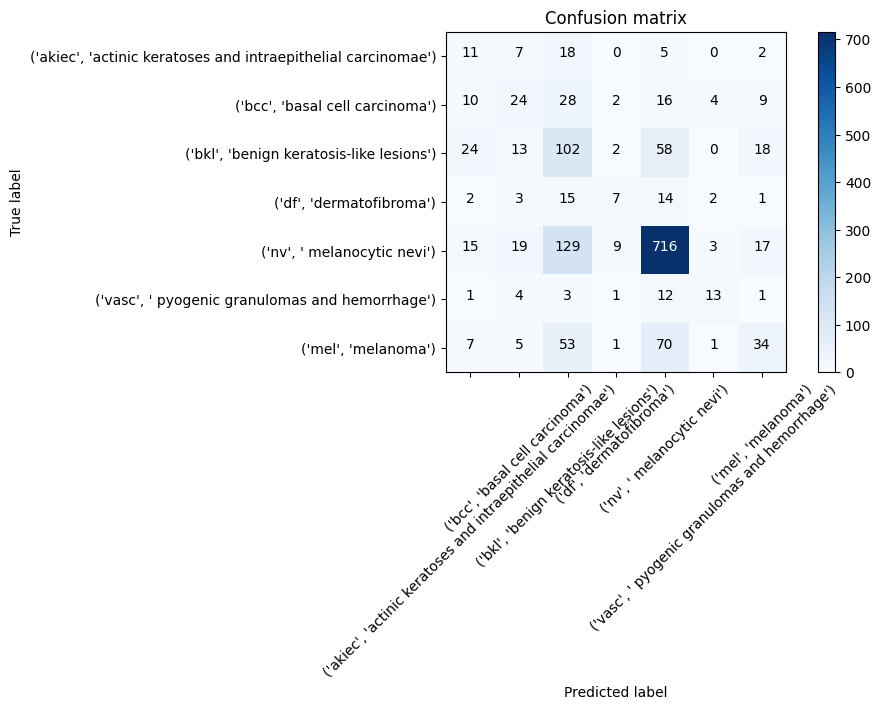

In [ ]:
# Pretrained VGG16 model
base_model_vgg16 = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg16.trainable = False

# Build your VGG16 model on top of the base model
model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Train and validate the VGG16 model
train_model(model_vgg16, X_train, Y_train)

# Evaluate the VGG16 model on test set
evaluate_model(model_vgg16, X_test, Y_test)

#Test model
test_model(model_vgg16, testset)

# VGG19

In [ ]:
# Pretrained VGG19 model
base_model_vgg19 = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg19.trainable = False

# Build your VGG19 model on top of the base model
model_vgg19 = Sequential([
    base_model_vgg19,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Train and validate the VGG19 model
train_model(model_vgg19, X_train, Y_train)

# Evaluate the VGG19 model on test set
evaluate_model(model_vgg19, X_test, Y_test)


#Test model
test_model(model_vgg19, testset)

# Model Explainability

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

def get_gradcam(model, image, layer_name=None):
    # Convert the image to the same size as the model's input
    image = cv2.resize(image, (model.input_shape[1], model.input_shape[2]))
    img_array = np.expand_dims(image, axis=0)

    # Create a new model that outputs the activations of the specified layer
    if layer_name is None:
        layer_name = model.layers[-2].name  # Use the second last layer by default
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Calculate the gradient with respect to the output class
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Get the gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(loss, conv_output)[0]

    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the corresponding gradient
    conv_output = conv_output[0]
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Calculate the heatmap by averaging the weighted feature maps
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    return superimposed_img, heatmap


if saved

In [ ]:
tes = pd.read_csv('https://drive.google.com/uc?id=' + '1kYWB6TAoQbaZHtQycE1Jue0lUKc62IV7')

# Assuming you have already trained the model and have an input image
# Load the input image
image = cv2.imread('tes')

# Get the GradCAM heatmap for the VGG16 model
heatmap_img, heatmap = get_gradcam(model_vgg16, image)

# Display the original image and the superimposed heatmap
cv2.imshow('Original Image', image)
cv2.imshow('GradCAM Heatmap', heatmap_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(Y_test, y_pred_ohe)
plt.show()

In [ ]:
pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from matplotlib import cm

def model_modifier_function(cloned_model):
    '''Modify model activation to use linear activation in the last layer.'''
    cloned_model.layers[-1].activation = tf.keras.activations.linear

def visualize_saliency(img, score, model_vgg16, model_modifier):
    # Create Saliency object.
    saliency = Saliency(model_vgg16, model_modifier=model_modifier, clone=True)

    # Generate saliency map.
    sal_map = saliency(score,
                       np.array(img),
                       smooth_samples=20,  # The number of calculating gradient iterations.
                       smooth_noise=0.20)  # Noise spread level.

    return sal_map

def visualize_gradcam(img, score, model_vgg16, model_modifier):
    # Create Gradcam object
    gradcam = Gradcam(model_vgg16, model_modifier, clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score, img, seek_penultimate_conv_layer=True)

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    return heatmap

def visualize_gradcam_plus(img, score, model_vgg16, model_modifier):
    # Create GradCAM++ object
    gradcam = GradcamPlusPlus(model_vgg16, model_modifier=model_modifier, clone=True)

    cam = gradcam(score, img)

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    return heatmap

# Assuming you have already defined model_vgg16 and testset

# Get a batch of test data
imgs, labs = testset.next()

# Visualize predictions for each image in the batch
for i, img in enumerate(imgs):
    plt.figure(figsize=(8, 6))

    # Get the true label and predicted score for the image
    true_label = labs[i]
    predicted_score = model_vgg16.predict(np.expand_dims(img, axis=0))

    # Visualize Saliency
    sal_map = visualize_saliency(img, true_label, model_vgg16, model_modifier_function)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sal_map[0], cmap='jet')
    plt.title('Saliency Map')
    plt.axis('off')

    # Visualize GradCAM
    heatmap = visualize_gradcam(img, true_label, model_vgg16, model_modifier_function)
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.5, cmap='jet')
    plt.title('GradCAM')
    plt.axis('off')

    plt.suptitle(f'True Label: {true_label} | Predicted Score: {predicted_score}')
    plt.show()


ValueError: ignored